In [1]:
## test model behavior in synthetic/real images.
## found model output one certain value after training.
## test general mse value

import os
from model import *
from data_loader import *
from utils import *
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import toy_utils
import torch.nn.functional as F
from helper_funcs import *

def load_checkpoint(ckpt_path, model):
    
    ckpt_dir = 'ckpt/'+ckpt_path

    print("[*] Loading model from {}".format(ckpt_dir))

    filename = 'rfc_model_best.pth.tar'
    ckpt_path = os.path.join(ckpt_dir, filename)
    ckpt = torch.load(ckpt_path)

    # load variables from checkpoint
    start_epoch = ckpt['epoch']
    best_loss = ckpt['best_valid_mse']
    print("current epoch: {} --- best loss: {}".format(start_epoch, best_loss))
    model.load_state_dict(ckpt['model_state'])
    #optimizer.load_state_dict(ckpt['optim_state'])   

    return model


In [2]:
model = focusLocNet(0.17, 1, 256, 2).to("cuda:0")

In [3]:
model = load_checkpoint('0507_16_13', model)

[*] Loading model from ckpt/0507_16_13
current epoch: 288 --- best loss: 0.668776384197207


In [4]:
model = model.eval()

In [5]:
def reset():
    h = [torch.zeros(1, 1, 256).cuda(),
                  torch.zeros(1, 1, 256).cuda()]
    l = torch.rand(1, 2).cuda()*2.0-1.0 #-0.5~0.5
    return h, l

In [27]:
video_path = "../datasets/DAVIS/test_davis_video_list.txt"
depth_path = "../datasets/DAVIS/test_davis_dpt_list.txt"
video_dataset = load_davis_dataset(video_path, depth_path, 4)[0]
dataiter = iter(video_dataset)

torch.Size([1, 4, 3, 1080, 1920])


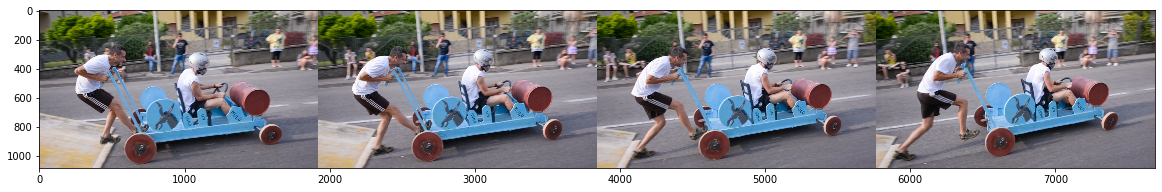

In [28]:
x_train, dpt = dataiter.next()
x_train = x_train.cuda()
dpt = dpt.cuda()
print(x_train.size())

# show images
imshow(torchvision.utils.make_grid(x_train[0]).cpu())


In [29]:
# plt.imshow(dpt[0][2][0].cpu())
# plt.colorbar()
# plt.show()

In [ ]:
from awnet import pwc_5x5_sigmoid_bilinear   # cm:import AWnet model
import torch
from torchvision import transforms, utils

AWnet = pwc_5x5_sigmoid_bilinear.pwc_residual().cuda()
AWnet.load_state_dict(torch.load('awnet/fs_34_all_0.03036882.pkl'))
AWnet = AWnet.eval()

import warnings
warnings.filterwarnings("ignore")

def fuseTwoImages(I, J_hat):
    with torch.no_grad():
        fusedTensor,warp,mask = AWnet(J_hat,I)
    return fusedTensor, warp, mask

def patchize(img):
    imgs = []
    H, W, C = img.shape
    ph = H//2
    pw = W//2
    img_empty = np.zeros((H+200, W+200, C))
    img_empty[100:-100, 100:-100] = img
    img = img_empty
    for i in range(2):
        for j in range(2):
            imgs.append(img[100+ph*i-50:100+ph*i+ph+50, 100+pw*j-32:100+pw*j+pw+32])
    imgs = np.stack(imgs)
    return imgs

def depatchize(imgs, pd_h = 50, pd_w = 32):
    ph = (imgs[0].shape[0]-2*pd_h)
    pw = (imgs[0].shape[1]-2*pd_w)
    img = np.zeros((ph*2, pw*2, 3))
    for i in range(2):
        for j in range(2):
            img[i*ph:i*ph+ph, j*pw:j*pw+pw] = imgs[i*2+j, pd_h:-pd_h, pd_w:-pd_w]
            
    return img
    
def image_fuse(a, b):
    aa = patchize(a)
    bb = patchize(b)
    aa = torch.Tensor(aa.transpose(0, 3, 1, 2)).cuda()
    bb = torch.Tensor(bb.transpose(0, 3, 1, 2)).cuda()

    ccs = []
    #wws = []
    for i in range(4):
        cc, ww, mask = fuseTwoImages(aa[i:i+1], bb[i:i+1])
        ccs.append(cc[0])
        #wws.append(ww[0])
    cc = torch.stack(ccs)
    #ww = torch.stack(wws)

    c = depatchize(cc.cpu().detach().numpy().transpose(0, 2, 3, 1))
    #warp = depatchize(ww.cpu().detach().numpy().transpose(0, 2, 3, 1))
    c = np.clip(c, 0, 1)
    return c

5674.2036
tensor([[0.9968, 0.9739]], device='cuda:0')
1962.1156
tensor([[-0.9998,  0.9987]], device='cuda:0')
7000.0
tensor([[0.9319, 0.9504]], device='cuda:0')
1988.6879
tensor([[-1.0000,  0.9991]], device='cuda:0')


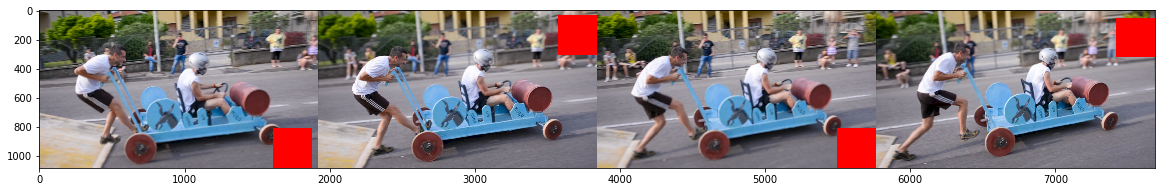

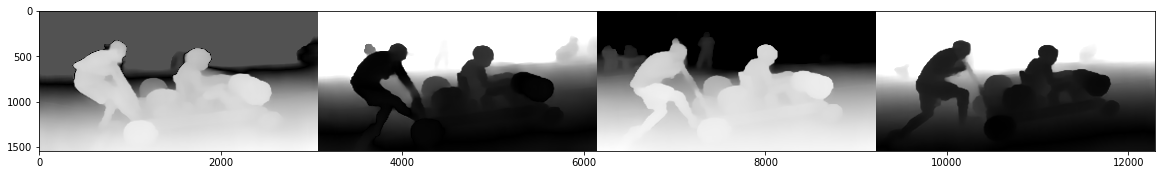

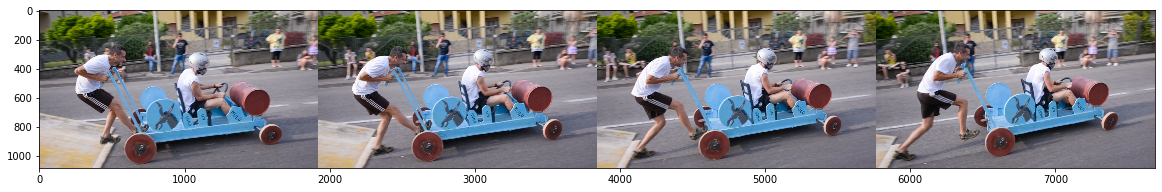

In [32]:
x_train = x_train.cuda()
dpt = dpt.cuda()


J_est = []
I_est = []
afs = []
locs = []
J_prev = None
last_af = None
h, l = reset()
with torch.no_grad():
    for t in range(x_train.size(1)):

        I, af, u_in  = getDefocuesImage(l, x_train[:, t, ...], dpt[:, t, ...])
#         if J_prev is None:
#             J_prev = I
#         else:
#             ## needs blockwise op
#             J_prev = fuseTwoImages(I, J_prev)

        I_est.append(I)
        last_af = af
        if last_af is None:
            input_t = af
        else:
            input_t = torch.min(af, last_af)

#         J_est.append(J_prev)
#         h, l = reset()
        afs.append(input_t)
        h, mu, l, _, _ = model(input_t, l, h)
        
        locs.append(l)
        print(mu)

#     J_est = torch.stack(J_est, dim = 1)
    I_est = torch.stack(I_est, dim = 1)
    afs = torch.stack(afs, dim = 1)
    locs = torch.stack(locs, dim = 1)
    
imshow(torchvision.utils.make_grid(color_region(I_est[0], locs[0])).cpu())
# imshow(torchvision.utils.make_grid(U_est[0]).cpu())
# imshow(torchvision.utils.make_grid(J_est[0]).cpu())
imshow(torchvision.utils.make_grid(afs[0]).cpu())
imshow(torchvision.utils.make_grid(x_train[0]).cpu())